<div class="alert alert-block alert-info"> 📌 Please note that this notebook is still a work in progress.</div>

## Overview 
<p>The National Football League (NFL) is back with another Big Data Bowl, where contestants use Next Gen Stats player tracking data to generate actionable, creative, and novel stats. Previous iterations have analyzed running backs, defensive backs, special teams, and pass rush plays, and have generated metrics that have been used on television and by NFL teams. This year's competition focuses on tackling 
<br></br>
<b>Goal:</b> Generate actionable, practical, and novel insights from player tracking data corresponding to tackling. </p>


<p><b>Examples include</b></p>
<ul>
    <li> Predictions of tackle time, probability, and/or location </li>
<li>  Tackle range: angle of pursuit, speed and acceleration, closing speed </li>
<li>  Player evaluation (e.g, yards saved, tackle value, missed tackles) </li>
<li>  Credit assignment (e.g, one player makes a tackle because of another players, blocks shed, area of influence) </li>
<li>  Tackle type (solo vs gang, open field vs in the trenches, etc) </li>
<li>  Team and player roles and responsibilities (setting the edge, filling gaps, etc) </li>
    </ul>

***

### <font color='289C4E' size=5 align>Table of contents<font><a class='anchor' id='top'></a>
- [Import Data](#1)
- [Feature Tools](#2)
- [Game Summary](#3)
- [Dataframe Relationships](#4)
- [New Metrics](#5)
- [Correlations](#6)
- [Modeling](#7)

***

# 1. Import Data <a class="anchor"  id="1"></a>

The first thing I'm going to do is read all of the data. For the tracking data, I'm going to concatenate the dataframes so that there is one comprehensive dataframe with all of the tracking info.

In [1]:
import pandas as pd
df_games=pd.read_csv('games.csv')
df_players=pd.read_csv('players.csv')
df_plays=pd.read_csv('plays.csv')
df_tackles=pd.read_csv('tackles.csv')


In [2]:
files=[]
for i in range(1,9):
    file='tracking_week_'+str(i)+'.csv'
    files.append(pd.read_csv(file))
    df_tracking=pd.concat(files)


# 2. Featuretools <a class="anchor"  id="2"></a>


I decided to use featuretools to generate player features based on all of the other game data, play data, tackle data, and tracking data. To do so, I needed to create a unique index for each dataframe. 

In [3]:
import featuretools as ft
df_plays.head()
df_plays['index']=df_plays['gameId'].astype(str)+df_plays['playId'].astype(str)+df_plays['ballCarrierDisplayName'].astype(str)
df_tackles['index']=df_tackles['gameId'].astype(str)+df_tackles['playId'].astype(str)+df_tackles['nflId'].astype(str)
df_tracking['index']=df_tracking['gameId'].astype(str)+df_tracking['playId'].astype(str)+df_tracking['nflId'].astype(str)+df_tracking['frameId'].astype(str)
df_plays['gameplayid']=df_plays['gameId'].astype(str)+df_plays['playId'].astype(str)
df_tackles['gameplayid']=df_tackles['gameId'].astype(str)+df_tackles['playId'].astype(str)
df_tracking['gameplayid']=df_tracking['gameId'].astype(str)+df_tracking['playId'].astype(str)
df_tracking['nflId'].fillna(0, inplace=True)
df_tracking['gameplayname']=df_tracking['gameId'].astype(str)+df_tracking['playId'].astype(str)+df_tracking['displayName'].astype(str)


In [4]:
df_plays[['gameId', 'playId', 'playDescription', 'gameClock']].sort_values(by=['gameId',  'gameClock']).head(10)

,gameId,playId,playDescription,gameClock
9714,2022090800,775,"(:17) (No Huddle, Shotgun) M.Stafford pass sho...",0:17
9916,2022090800,1836,(:26) (Shotgun) M.Stafford pass short left to ...,0:26
1131,2022090800,2648,(:33) (Shotgun) J.Allen up the middle to BUF 4...,0:33
10476,2022090800,1757,(:39) M.Stafford scrambles right end ran ob at...,0:39
1363,2022090800,236,(10:03) J.Allen pass short right to G.Davis fo...,10:03
8945,2022090800,2163,(10:07) D.Singletary left end to LA 22 for 13 ...,10:07
4657,2022090800,2958,(10:19) (Shotgun) J.Allen right guard to BUF 4...,10:19
3425,2022090800,2137,(10:34) (Shotgun) J.Allen scrambles up the mid...,10:34
5055,2022090800,212,(10:42) (Shotgun) J.Allen pass short right to ...,10:42
9029,2022090800,2934,(11:01) (Shotgun) J.Allen pass short right to ...,11:01


Just for an extra resource, I'm going to create descriptions of each game by adding all the play descriptions together for each game.

# 3. Create summary of game <a class="anchor"  id="#"></a>

In [5]:
df_playdescription = df_plays[['gameId', 'playId', 'playDescription', 'gameClock']].sort_values(by=['gameId',  'gameClock']).set_index('gameId')


In [6]:
df_gamedescription=df_playdescription.groupby(['gameId'])[['playDescription']].transform(lambda x: ','.join(x)).reset_index().drop_duplicates()
df_gamedescription.rename(columns={'playDescription':'gameDescription'}, inplace=True)

In [7]:
#df_gamedescription.to_csv('gamedescription.csv')

# 4. Create relationships between dataframes  <a class="anchor"  id="4"></a>

I put the five dataframes together by identifying their index and key columns to form a final player dataframe with features for each player based on all the other data that can be joined to them.

In [8]:
dataframes = {
    "games": (df_games, "gameId"),
    "players": (df_players, "nflId"),
    "plays": (df_plays, "index"),
    "tackles": ( df_tackles, "index"),
    "tracking": (df_tracking, "index")
}

In [9]:
relationships = [
    ("games", "gameId", "plays", "gameId"), #games and plays join in gameid
    ("plays", "index", "tracking", "gameplayname"), #plays and tracking join on game id, play id, and ball carrier player name
    ("players", "nflId", "tackles", "nflId"), #players and tackles join on nflid
    ("players", "nflId", "tracking", "nflId"), #players and tracking join on nflid
    ("tackles", "index", "plays", "gameplayid"), #tackles and plays join on gameid and playid
    
    
    
]

In [10]:
import warnings
warnings.filterwarnings('ignore')

feature_matrix_players, features_defs = ft.dfs(
    dataframes=dataframes,
    relationships=relationships,
    target_dataframe_name="players",
)


In [11]:
df_final=feature_matrix_players.reset_index()
df_final

,nflId,height,weight,collegeName,position,COUNT(tackles),MAX(tackles.assist),MAX(tackles.forcedFumble),MAX(tackles.gameId),MAX(tackles.gameplayid),...,SUM(tracking.plays.playResult),SUM(tracking.plays.prePenaltyPlayResult),SUM(tracking.plays.preSnapHomeScore),SUM(tracking.plays.preSnapHomeTeamWinProbability),SUM(tracking.plays.preSnapVisitorScore),SUM(tracking.plays.preSnapVisitorTeamWinProbability),SUM(tracking.plays.quarter),SUM(tracking.plays.visitorTeamWinProbilityAdded),SUM(tracking.plays.yardlineNumber),SUM(tracking.plays.yardsToGo)
0,25511,6-4,225,Michigan,QB,0,NaN,NaN,NaN,NaN,...,-477.0,1035.0,2070.0,83.193253,1934.0,83.806747,585.0,2.077718,4034.0,784.0
1,29550,6-4,328,Arkansas,T,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,29851,6-2,225,California,QB,0,NaN,NaN,NaN,NaN,...,999.0,829.0,2419.0,128.047965,1165.0,11.952035,420.0,-0.279937,3844.0,960.0
3,30842,6-6,267,UCLA,TE,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,33084,6-4,217,Boston College,QB,0,NaN,NaN,NaN,NaN,...,331.0,331.0,2705.0,91.580663,4058.0,178.419337,852.0,-0.057118,10458.0,1941.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,55200,6-6,266,Indiana,DT,1,0.0,0.0,2.022102e+09,2.022102e+13,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1679,55212,6-0,230,Iowa State,ILB,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1680,55239,6-2,300,Pennsylvania,DT,3,1.0,0.0,2.022100e+09,2.022100e+13,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1681,55240,6-1,185,Buffalo,CB,3,1.0,0.0,2.022101e+09,2.022101e+13,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


# 5. New Metrics <a class="anchor"  id="5"></a>

Now that I have a final dataframe with one row per player with all the aggregated stats, I'm going to look at which features are related to successful tackles. To do this, I want to make three additional merics:
 - tackle_success_rate = the sum of tackles divided by sum of tackles plus missed tackles
 - assist_success_rate = sum of assists divided by sum of assists and missed tackles
 - tackleassist_rate = sum of tackles + (.5 * sum of assists) divided by sum of tackles, sum of assists, and sum of missed tackles
 

In [12]:
df_final['tackle_success_rate']=(df_final['SUM(tackles.tackle)'])/(df_final['SUM(tackles.tackle)']+df_final['SUM(tackles.pff_missedTackle)'])
df_final['assist_success_rate']=(df_final['SUM(tackles.assist)'])/(df_final['SUM(tackles.assist)']+df_final['SUM(tackles.pff_missedTackle)'])

In [13]:
df_final['tackleassist_rate']=((df_final['SUM(tackles.tackle)'])+(.5 * df_final['SUM(tackles.assist)']))/((df_final['SUM(tackles.assist)']+(df_final['SUM(tackles.tackle)'])+df_final['SUM(tackles.pff_missedTackle)']))

### Findings:

- There are 770 players with tackle or missed tackle data and 258 players have over a 90% tackle success rate.
- There are 756 players with assist or missed tackle data and 189 players have over a 90% assist success rate.
- There are 800 players with assist, tackle, or missed tackle data. 173 have >=80% tackle assist success rate/
 - I created 3 binary flags for these cutoff points


In [14]:
print(len(df_final[df_final['tackle_success_rate']>=.9]))
print(len(df_final[df_final['tackle_success_rate'].isna()==False]))

258
770


In [15]:
print(len(df_final[df_final['assist_success_rate']>=.9]))
print(len(df_final[df_final['assist_success_rate'].isna()==False]))

189
756


In [16]:
print(len(df_final[df_final['tackleassist_rate']>=.8]))
print(len(df_final[df_final['tackleassist_rate'].isna()==False]))

173
800


In [17]:
import numpy as np
df_final['90tackle_success']=np.where(df_final['tackle_success_rate']>=.90, 1, 0)
df_final['90assist_success']=np.where(df_final['assist_success_rate']>=.90, 1, 0)
df_final['80tackleassist_success']=np.where(df_final['tackleassist_rate']>=.8, 1, 0)

In [18]:

numeric_columns = df_final.select_dtypes(include='number').columns

print(numeric_columns)

Index(['nflId', 'weight', 'COUNT(tackles)', 'MAX(tackles.assist)',
       'MAX(tackles.forcedFumble)', 'MAX(tackles.gameId)',
       'MAX(tackles.gameplayid)', 'MAX(tackles.pff_missedTackle)',
       'MAX(tackles.playId)', 'MAX(tackles.tackle)',
       ...
       'SUM(tracking.plays.quarter)',
       'SUM(tracking.plays.visitorTeamWinProbilityAdded)',
       'SUM(tracking.plays.yardlineNumber)', 'SUM(tracking.plays.yardsToGo)',
       'tackle_success_rate', 'assist_success_rate', 'tackleassist_rate',
       '90tackle_success', '90assist_success', '80tackleassist_success'],
      dtype='object', length=1467)


# 6. Correlations for numeric columns <a class="anchor"  id="5"></a>

I'm going to look at any correlations >.25 or <-.25. First I'll look at features correlated with the  85% tackle assist success rate.

In [19]:
correlation1=df_final[numeric_columns].corr()['80tackleassist_success'].reset_index()
correlation1[(correlation1['80tackleassist_success']>.15)| (correlation1['80tackleassist_success']<-.15) ]

,index,80tackleassist_success
1,weight,-0.172426
3,MAX(tackles.assist),-0.353696
7,MAX(tackles.pff_missedTackle),-0.442260
10,MEAN(tackles.assist),-0.437762
14,MEAN(tackles.pff_missedTackle),-0.359008
16,MEAN(tackles.tackle),0.627206
20,MIN(tackles.gameplayid),0.189317
22,MIN(tackles.playId),0.220612
23,MIN(tackles.tackle),0.459279
24,SKEW(tackles.assist),0.397314


In [20]:
correlation1=df_final[numeric_columns].corr()['tackleassist_rate'].reset_index()
correlation1[((correlation1['tackleassist_rate']>.2) | (correlation1['tackleassist_rate']<-.2)) ]

,index,tackleassist_rate
1,weight,-0.254078
3,MAX(tackles.assist),-0.235358
7,MAX(tackles.pff_missedTackle),-0.321905
9,MAX(tackles.tackle),0.557672
10,MEAN(tackles.assist),-0.499371
14,MEAN(tackles.pff_missedTackle),-0.722470
16,MEAN(tackles.tackle),0.908499
17,MIN(tackles.assist),-0.275838
21,MIN(tackles.pff_missedTackle),-0.414479
23,MIN(tackles.tackle),0.476007


## My Key Takeaways

Based on the output, I'm interested in looking at a few features and how they relate to tackle success rate:
1. A player's range of y vlaues on the field: a higher range is associated with a better tackle assist rate
2. A player's average speed (s): higher speed is associated with better success rate
3. The distance travelled during a play: There is a positive correlation between distance and tackle assist success rate

In [21]:
df_final['y_range']=df_final['MAX(tracking.y)']-df_final['MIN(tracking.y)']
df_final['acceleration_range']=df_final['MAX(tracking.a)']-df_final['MIN(tracking.a)']
df_final['speed_range']=df_final['MAX(tracking.s)']-df_final['MIN(tracking.s)']

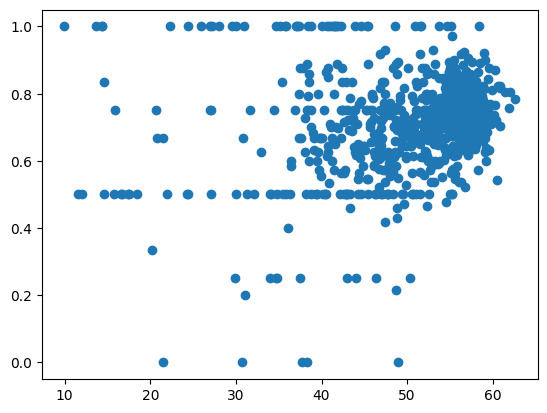

In [22]:
df_tackle_data=df_final[(df_final['tackleassist_rate'].isna()==False)]
import matplotlib.pyplot as plt
plt.scatter(x=df_tackle_data['y_range'], y=df_tackle_data['tackleassist_rate'])

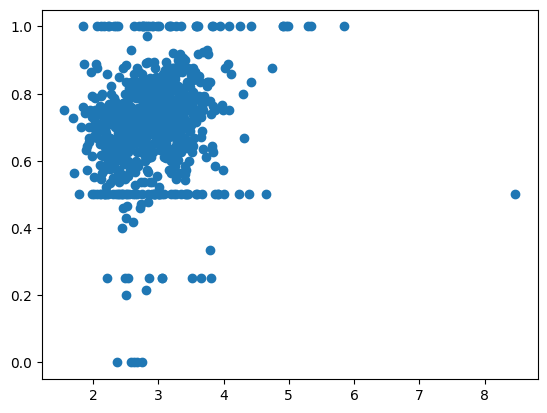

In [23]:
plt.scatter(x=df_tackle_data['MEAN(tracking.s)'], y=df_tackle_data['tackleassist_rate'])

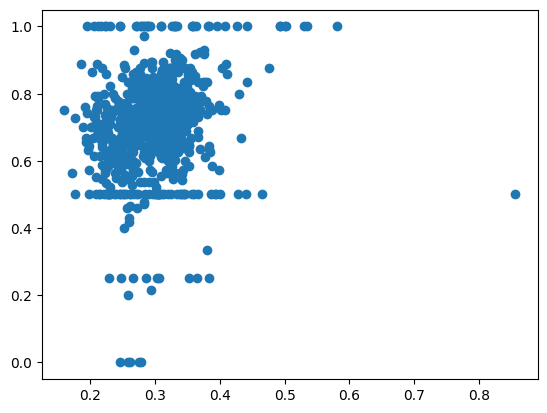

In [24]:
plt.scatter(x=df_tackle_data['MEAN(tracking.dis)'], y=df_tackle_data['tackleassist_rate'])


In [25]:
(df_tackle_data['tackleassist_rate']*100).describe()

count    800.000000
mean      70.730410
std       14.843641
min        0.000000
25%       64.285714
50%       72.222222
75%       78.333333
max      100.000000
Name: tackleassist_rate, dtype: float64

# 7. Modeling  <a class="anchor"  id="7"></a>

The next part of the notebook focuses on predicting tackle assist success rate per player and tackle success per play.

In [28]:
X=df_tackle_data[['y_range', 'acceleration_range', 'speed_range','MEAN(tracking.dis)','MEAN(tracking.a)','STD(tracking.a)', 'MEAN(tracking.s)', 'STD(tracking.s)', 'SKEW(tracking.y)' , 'MIN(tracking.x)', 'MIN(tracking.y)']]
X.fillna(0, inplace=True)
y=df_tackle_data['tackleassist_rate']*100
y.fillna(0, inplace=True)
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the model
model = LGBMRegressor(learning_rate=.09, max_depth=3,num_iterations=100)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 11
[LightGBM] [Info] Start training from score 70.573047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [29]:
X=df_tackle_data[['y_range', 'acceleration_range', 'speed_range','MEAN(tracking.dis)','MEAN(tracking.a)','STD(tracking.a)', 'MEAN(tracking.s)', 'STD(tracking.s)', 'SKEW(tracking.y)' , 'MIN(tracking.x)', 'MIN(tracking.y)']]
X.fillna(0, inplace=True)
y=df_tackle_data['tackle_success_rate']*100
y.fillna(0, inplace=True)
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the model
model = LGBMRegressor(learning_rate=.04, max_depth=5, num_iterations=40)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 11
[LightGBM] [Info] Start training from score 78.186598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Predict success flag

In [30]:
df_final['80tackleassist_success'].value_counts()

80tackleassist_success
0    1510
1     173
Name: count, dtype: int64

In [31]:
X=df_final[['y_range', 'acceleration_range', 'speed_range','MEAN(tracking.dis)','MEAN(tracking.a)','STD(tracking.a)', 'MEAN(tracking.s)', 'STD(tracking.s)', 'SKEW(tracking.y)' , 'MIN(tracking.x)', 'MIN(tracking.y)']]
X.fillna(0, inplace=True)
y=df_final['80tackleassist_success']
y.fillna(0, inplace=True)
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.2, random_state=1)

# Create the model
model = LGBMClassifier(learning_rate=.15, max_depth=2, class_weight={0:.3, 1:.7})

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

[LightGBM] [Info] Number of positive: 138, number of negative: 1208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 1346, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210458 -> initscore=-1.322170
[LightGBM] [Info] Start training from score -1.322170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

# 

In [32]:
df_merge=pd.merge(df_plays, df_tackles, left_on='gameplayid', right_on='gameplayid')



In [33]:
tracking_tackles=df_tracking[df_tracking['event']=='tackle']

In [34]:
df_merge=pd.merge(df_merge, tracking_tackles, left_on='gameplayid', right_on='gameplayid')

In [35]:
df_merge['pff_missedTackle'].value_counts()

pff_missedTackle
0    277134
1     32613
Name: count, dtype: int64

In [36]:
X=df_merge[['x', 'y', 's', 'a', 'dis', 'o', 'absoluteYardlineNumber', 'offenseFormation', 
       ]]

y=df_merge['pff_missedTackle']
y.fillna(0, inplace=True)
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

# Create the model
model = LGBMClassifier(learning_rate=.04,max_iter=400, max_depth=4,class_weight={0:.25, 1:.75})

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

print("F1:", f1_score(y_pred, y_test))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

[LightGBM] [Warning] num_iterations is set=400, max_iter=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Info] Number of positive: 24460, number of negative: 207850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 232310, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260925 -> initscore=-1.041165
[LightGBM] [Info] Start training from score -1.041165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [37]:
X=df_merge[['x', 'y', 's', 'a', 'dis', 'o', 'absoluteYardlineNumber', 'offenseFormation', 
       'passProbability', ]]

y=df_merge['tackle']
y.fillna(0, inplace=True)
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=1)

# Create the model
model = LGBMClassifier(learning_rate=.04,max_iter=500, max_depth=3)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

print("F1:", f1_score(y_pred, y_test))

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Info] Number of positive: 135456, number of negative: 112341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 247797, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546641 -> initscore=0.187108
[LightGBM] [Info] Start training from score 0.187108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe